# Import and visualize images to test translational variance on

Original image size of cat1_translationalVariance.png is 368 x 468 x 3.
Original image size of cat2_translationalVariance.png is 392 x 548 x 3.


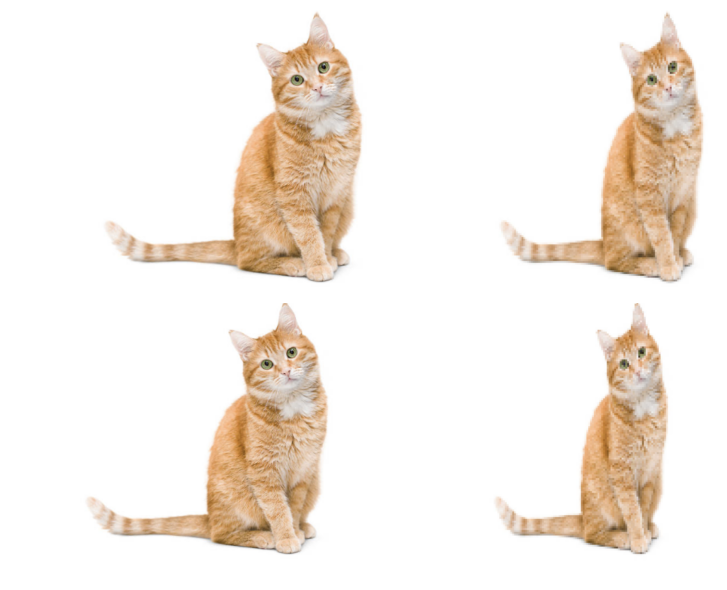

In [1]:
import os
import matplotlib.pyplot as plt
import cv2, numpy as np, tensorflow as tf, numpy as np

cat1_image_path = "../images/cat1_translationalVariance.png"
cat2_image_path = "../images/cat2_translationalVariance.png"

IMG_SIZE = 150

img_arrays, resized_arrays = [], []
for img_path in [cat1_image_path, cat2_image_path]:
    img_array = cv2.imread(img_path) # read in BGR order
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # BGR to RGB
    img_arrays.append(img_array)
    print(f"Original image size of {os.path.basename(img_path)} is {' x '.join([str(x) for x in img_array.shape])}.")
    new_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE));resized_arrays.append(new_img_array)

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax[0][0].imshow(img_arrays[0]);ax[1][0].imshow(img_arrays[1])
ax[0][1].imshow(resized_arrays[0]);ax[1][1].imshow(resized_arrays[1])

for i in range(2):
    for j in range(2):
        ax[i][j].axis('off')  # Turn off axis numbers and ticks

plt.tight_layout()

plt.show()

# Test the convolution operation

Shape of kernel filter = 3 x 3 x 3 x 1
Shape of 4d image is 1 x 150 x 150 x 3
Shape of 4d image is 1 x 150 x 150 x 3


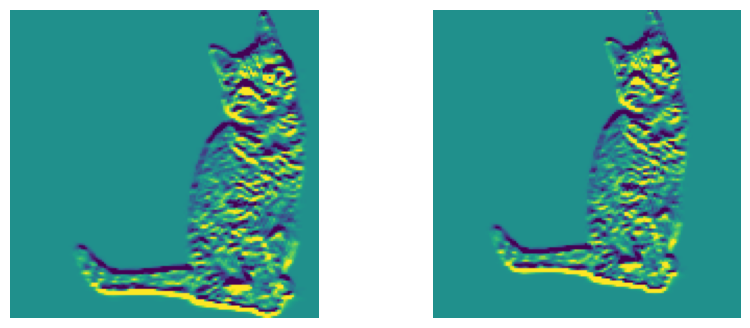

In [2]:
filter_kernel_1d = np.array([
    -1,-1,-1,
    0,0,0,
    1,1,1
]).astype(np.float32)
filter_kernel_2d = filter_kernel_1d.reshape(3,3)
filter_kernel_3d_temp = np.expand_dims(filter_kernel_2d, axis=-1) # (3,3) -> (3,3,1)
filter_kernel_3d = np.repeat(filter_kernel_3d_temp, 3, axis=-1) # (3,3,1) --> (3,3,3)
filter_kernel = np.expand_dims(filter_kernel_3d, axis=-1) # (3,3,3) ---> (3,3,3,1)
print(f"Shape of kernel filter = {' x '.join([str(x) for x in filter_kernel.shape])}")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i, resized_img in enumerate(resized_arrays):
    # expand image array to account for the same dimensionality as that of the kernel filter
    image_4d = np.expand_dims(resized_arrays[i], axis=0) # (x,y,..) --> (x, y,...,1)
    print(f"Shape of 4d image is {' x '.join([str(x) for x in image_4d.shape])}")

    # Convert numpy arrays to TensorFlow tensors
    image_tensor = tf.constant(image_4d, dtype=tf.float32)
    filter_tensor = tf.constant(filter_kernel, dtype=tf.float32)

    # Perform convolution using tf.nn.conv2d
    output_tensor = tf.nn.conv2d(input=image_tensor, filters=filter_tensor, strides=[1, 1, 1, 1], padding='VALID')

    # Normalize the convolution output to the range -255 to 255
    normalized_output = tf.clip_by_value(output_tensor, -255, 255)  # Clip values outside the range
    normalized_output = tf.squeeze(tf.squeeze(tf.cast(normalized_output, tf.float32), axis=0), axis=-1)

    ax[i].imshow(normalized_output)
    ax[i].axis('off')
plt.show()

# Test the pooling operation

In [3]:
# dimmen the image so that white pixels are 

def dimmen_image(image, dim_factor = 0.5, threshold = 200, print_image = False):
    # Create a mask where white pixels are identified
    # This will create a mask for pixels that are above the threshold
    white_mask = (image[:, :, 0] > threshold) & (image[:, :, 1] > threshold) & (image[:, :, 2] > threshold)

    # print(image[white_mask].shape)

    # Dim down the white pixels by reducing their intensity
    # You can adjust the factor to control how much to dim down
    dim_factor = 0.5
    new_image = image.copy()
    new_image[white_mask] = new_image[white_mask] * dim_factor

    return new_image

In [4]:
print(resized_arrays[0][:, :, 0].max(), resized_arrays[0][:, :, 0].min())
print(resized_arrays[0][:, :, 1].max(), resized_arrays[0][:, :, 1].min())
print(resized_arrays[0][:, :, 2].max(), resized_arrays[0][:, :, 2].min())

255 18
255 15
255 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [127.0..249.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [127.0..248.0].


Shape of 4d image is 1 x 150 x 150 x 3
pooling operation output has shape = (1, 51, 51, 3)
Normalized output has shape = (51, 51, 3)
Shape of 4d image is 1 x 150 x 150 x 3
pooling operation output has shape = (1, 51, 51, 3)
Normalized output has shape = (51, 51, 3)


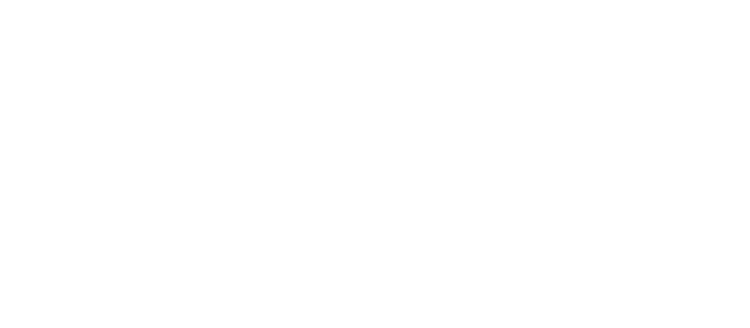

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i, resized_img in enumerate(resized_arrays):
    # expand image array to account for the same dimensionality as that of the kernel filter
    image_4d = np.expand_dims(dimmen_image(resized_arrays[i], dim_factor=0.1), axis=0) # (x,y,..) --> (1, x, y...)
    print(f"Shape of 4d image is {' x '.join([str(x) for x in image_4d.shape])}")

    # Convert numpy arrays to TensorFlow tensors
    image_tensor = tf.constant(image_4d, dtype=tf.float32)

    # Perform max pooling with a window size of 3x3 and stride of 2
    output_tensor = tf.nn.max_pool(input=image_tensor,
                                    ksize=[1, 50, 50, 1], # kernel size
                                    strides=[1, 2, 2, 1], # stride
                                    padding='VALID') # no padding
    
    print(f"pooling operation output has shape = {output_tensor.shape}")

    # Normalize the convolution output to the range -255 to 255
    normalized_output = tf.clip_by_value(output_tensor, -255, 255)  # Clip values outside the range
    normalized_output = tf.squeeze(tf.cast(normalized_output, tf.float32), axis=0)
    print(f"Normalized output has shape = {normalized_output.shape}")

    ax[i].imshow(normalized_output)
    ax[i].axis('off')
plt.show()

- turns out that due to most of the image being white(and openCV imread makes white pixel the brightest), the maxpool yields a white image, even when the image is translated
- our doubts could be clarified if we were to invert the image, so let's try that.

# Let's try with inverting the images, i.e. using Negatives

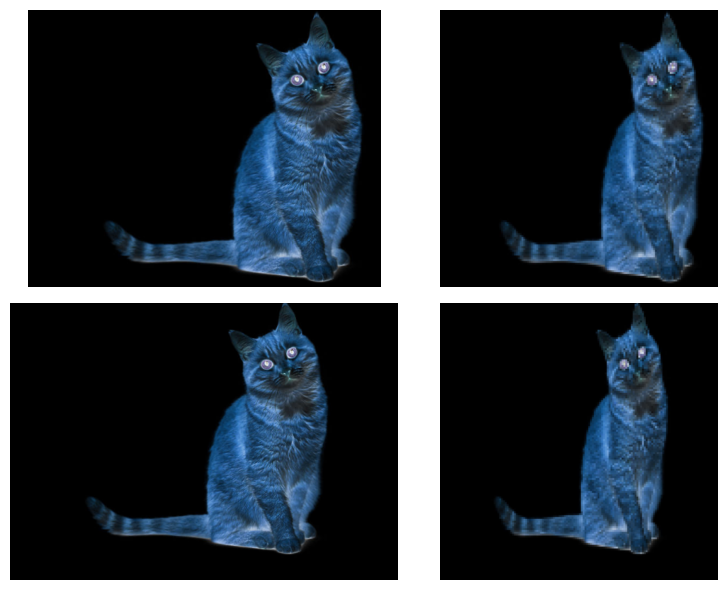

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
for i in range(2):
    ax[i][0].imshow(255 - img_arrays[i])
    ax[i][1].imshow(255 - resized_arrays[i])
    ax[i][0].imshow(255 - img_arrays[i])
    ax[i][1].imshow(255 - resized_arrays[i])

for i in range(2):
    for j in range(2):
        ax[i][j].axis('off')  # Turn off axis numbers and ticks

plt.tight_layout()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..240.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..240.0].


Shape of 4d negative image is 1 x 150 x 150 x 3
pooling operation output has shape = (1, 51, 51, 3)
Normalized output has shape = (51, 51, 3)
Shape of 4d negative image is 1 x 150 x 150 x 3
pooling operation output has shape = (1, 51, 51, 3)
Normalized output has shape = (51, 51, 3)


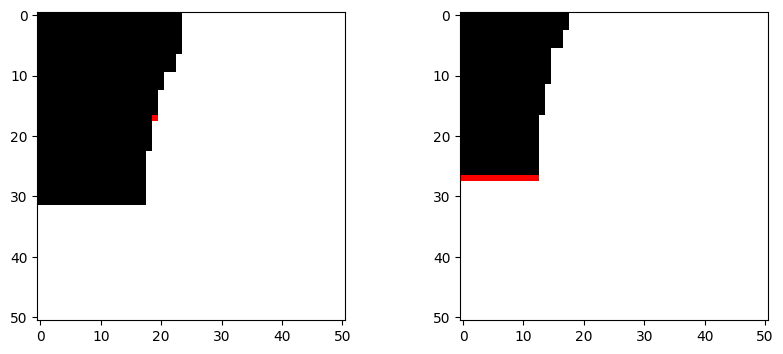

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i, resized_img in enumerate(resized_arrays):
    # let's flip the image and try
    negative_image_arr = resized_arrays[i].copy()
    negative_image_arr = 255 - negative_image_arr

    # expand image array to account for the same dimensionality as that of the kernel filter
    image_4d = np.expand_dims(negative_image_arr, axis=0) # (x,y,..) --> (1, x, y...)
    print(f"Shape of 4d negative image is {' x '.join([str(x) for x in image_4d.shape])}")

    # Convert numpy arrays to TensorFlow tensors
    image_tensor = tf.constant(image_4d, dtype=tf.float32)

    # Perform max pooling with a window size of 3x3 and stride of 2
    output_tensor = tf.nn.max_pool(input=image_tensor,
                                    ksize=[1, 50, 50, 1], # kernel size
                                    strides=[1, 2, 2, 1], # stride
                                    padding='VALID') # no padding
    
    print(f"pooling operation output has shape = {output_tensor.shape}")

    # Normalize the convolution output to the range -255 to 255
    normalized_output = tf.clip_by_value(output_tensor, -255, 255)  # Clip values outside the range
    normalized_output = tf.squeeze(tf.cast(normalized_output, tf.float32), axis=0)
    print(f"Normalized output has shape = {normalized_output.shape}")

    ax[i].imshow(normalized_output)
    # ax[i].axis('off')
plt.show()

- So with enough translation, even pooling operation is translationally variant
To reduce this issue, modern convolutional networks often employ strategies like:

1. Overlapping Pooling: Using smaller strides relative to the kernel size ensures more overlap between adjacent pooling regions. This can smooth out the transition caused by shifts.
2. Global Pooling: Instead of fixed regions, global pooling (e.g., global average pooling) operates over the entire spatial extent, reducing sensitivity to translations.
3. Use of Convolutions: Some architectures replace pooling layers with strided convolutions, which can learn to mitigate translational variance as part of the training process.
4. Equivariant Architectures: Advanced techniques like spatial transformer networks or equivariant networks (e.g., SE(2)-equivariant CNNs) aim to handle transformations like translations more robustly.